# LightGBM

This sub-repository contains the Python notebooks for the tutorial "Survival of the Fittest: Classical and Machine Learning Methods for Time-to-Event Modeling" of D. Meier and A. Sturge for the Data Science Working Group of the Swiss Actuarial Association, see https://actuarialdatascience.org.

Before running this notebook make sure that you have created all datasets by running the two notebooks "IPUMS NHIS Dataset" and "Synthetic Dataset".

In [1]:
import polars as pl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import lightgbm as lgb
from sksurv.util import Surv
from sklearn.model_selection import train_test_split, GridSearchCV
from sksurv.metrics import concordance_index_censored, integrated_brier_score
from sklearn.metrics import log_loss
from scipy.special import logit
import time
import sys
import importlib

modules = [
    'polars',
    'pandas',
    'seaborn',
    'matplotlib',
    'numpy',
    'lightgbm',
    'sksurv',
    'sklearn',
    'scipy'
]

print(f"Python version: {sys.version}\n")

for module in modules:
    try:
        mod = importlib.import_module(module)
        version = getattr(mod, '__version__', 'built-in or no __version__')
        print(f"{module} version: {version}")
    except ImportError:
        print(f"{module} is not installed.")

sns.set()

Python version: 3.9.21 (main, Dec 11 2024, 10:23:52) 
[Clang 14.0.6 ]

polars version: 1.29.0
pandas version: 1.5.3
seaborn version: 0.13.2
matplotlib version: 3.9.2
numpy version: 1.26.4
lightgbm version: 4.6.0
sksurv version: 0.21.0
sklearn version: 1.2.2
scipy version: 1.13.1


In [2]:
# Loading prepared NHIS data
df = pl.read_csv("data/prepared_data.csv")
df = df.with_columns(pl.col("earnings_quantile").cast(pl.Float64))
df = df.with_columns(pl.col("HRSLEEP").cast(pl.Int64))

dfp = df.to_pandas()
dfp_nn = dfp.dropna()

X = dfp_nn.drop(columns=["time", "event"])
T = dfp_nn["time"].to_numpy()
E = dfp_nn["event"].to_numpy()

y = Surv.from_arrays(event=E.astype(bool), time=T)

X_train, X_test, E_train, E_test, T_train, _, y_train, y_test = train_test_split(X, E, T, y, test_size=0.2, random_state=0)
X_train = X_train[T_train >= 2] # remove individuals that died before year 2
y_train = y_train[T_train >= 2]
E_train = E_train[T_train >= 2]
T_train = T_train[T_train >= 2]
E_train = (E_train == 1) & (T_train>=2) & (T_train<3) # consider the binary case of year of death - survey year = 2
X_train, X_val, E_train, E_val, y_train, y_val = train_test_split(X_train, E_train, y_train, test_size=0.2, random_state=0)

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[110]	train's binary_logloss: 0.0516978	val's binary_logloss: 0.0525079
Fitting time: 32.84 seconds


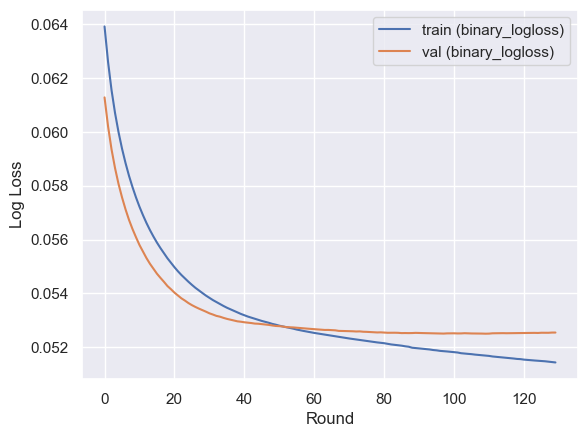

Log loss train: 0.051697786513101314
Log loss val:  0.0525079260210954


In [3]:
params = dict(
    learning_rate=0.05,
    objective="binary",
    metric="binary_logloss",
    num_leaves=6,
    verbose=0,
    seed=0,
)

evals_result = {}
train_data = lgb.Dataset(X_train, label=E_train)
val_data = lgb.Dataset(X_val, label=E_val)

start_time = time.time()

lgb_model = lgb.train(
    params,
    train_set=train_data,
    valid_sets=[train_data, val_data],
    valid_names=["train", "val"],
    num_boost_round=1000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=20),
        lgb.record_evaluation(evals_result),
    ],
)

print(f"Fitting time: {time.time() - start_time:.2f} seconds")

for dataset in evals_result.keys():
    metric_values = evals_result[dataset]["binary_logloss"]
    plt.plot(metric_values, label=f"{dataset} (binary_logloss)")
plt.xlabel("Round")
plt.ylabel("Log Loss")
plt.legend()
plt.show()

print("Log loss train: " + str(log_loss(E_train, lgb_model.predict(X_train))))
print("Log loss val:  " + str(log_loss(E_val, lgb_model.predict(X_val))))

In [4]:
# C-index
pred = lgb_model.predict(X_test)
c_index = concordance_index_censored(y_test["event"], y_test["time"], pred)[0]
print(f"C-index: {c_index:.4f}")

# IBS
time_grid = np.arange(1, 10)
lambdas = -np.log(1 - pred)
surv_preds = np.exp(-np.outer(lambdas, time_grid))  # assume S(t) = exp(-lambda * t)
ibs = integrated_brier_score(y_test, y_test, surv_preds, time_grid)
print(f"Integrated Brier Score: {ibs:.4f}")

# Log loss for interval [2, 3)
in_interval = ((y_test["event"] == True) & (y_test["time"] >= 2) & (y_test["time"] < 3)).astype(int)
p_interval = surv_preds[:, 2] - surv_preds[:, 3]
logloss = log_loss(in_interval, p_interval)
print(f"Log loss for interval [2, 3): {logloss:.4f}")

C-index: 0.8599
Integrated Brier Score: 0.0415
Log loss for interval [2, 3): 0.0502


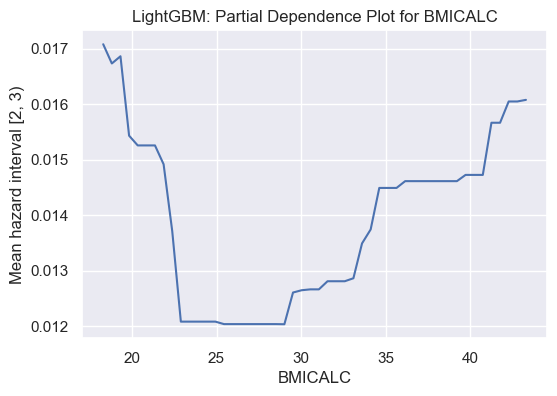

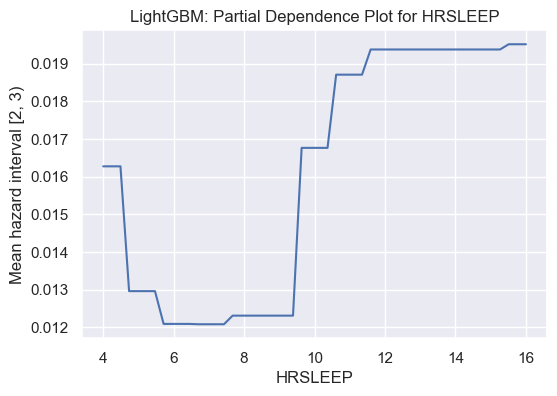

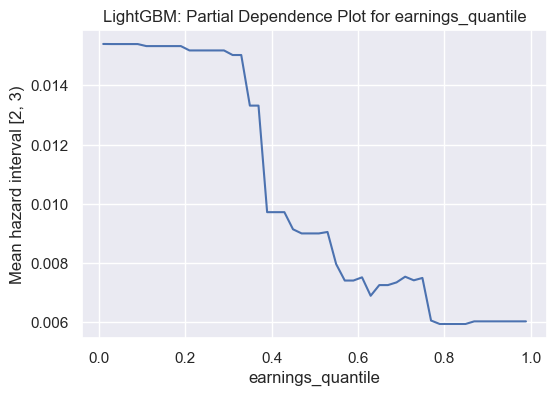

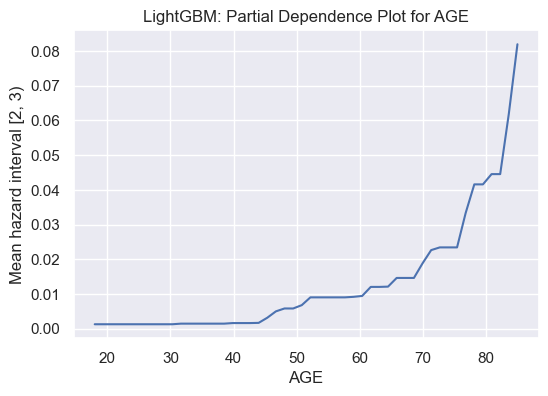

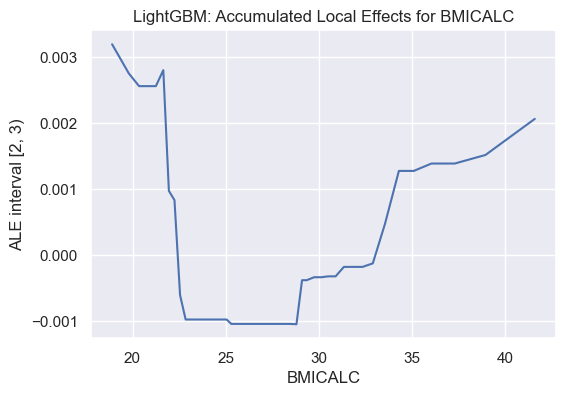

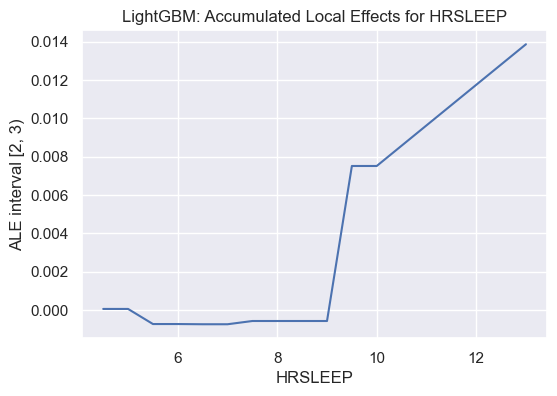

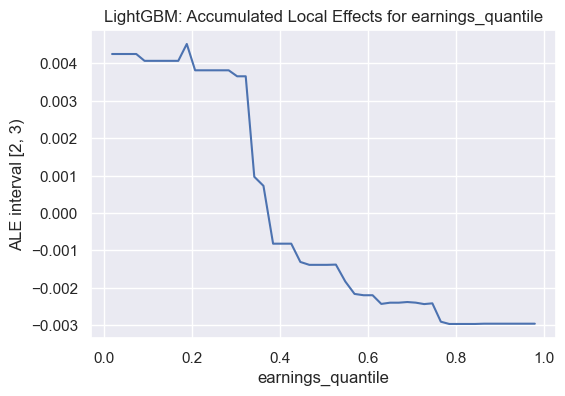

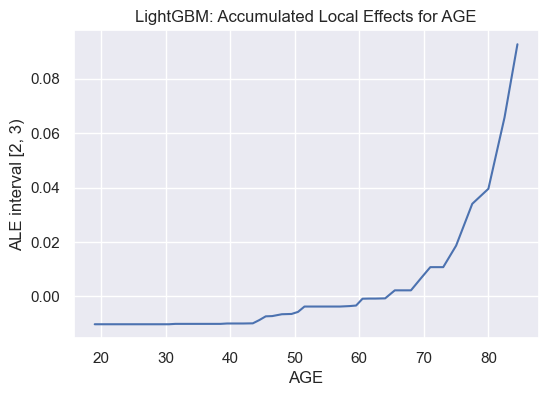

In [5]:
def plot_pdp(model, df, variable, t1, t2):
    x_vals = np.linspace(df[variable].quantile(0.01), df[variable].quantile(0.99), 50)
    y_vals = []
    for val in x_vals:
        df_copy = df.copy()
        df_copy[variable] = val
        y_vals.append(model.predict(df_copy).mean())
    plt.figure(figsize=(6, 4))
    plt.plot(x_vals, y_vals)
    plt.xlabel(variable)
    plt.ylabel(f"Mean hazard interval [{t1}, {t2})")
    plt.title(f"LightGBM: Partial Dependence Plot for {variable}")
    plt.show()

def plot_ale(model, df, variable, t1, t2):
    df_sorted = df.sort_values(by=variable)
    quantiles = np.linspace(0.01, 0.99, 51)
    bin_edges = df[variable].quantile(quantiles).values
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    
    ale_values = []
    for i in range(len(bin_edges) - 1):
        lower, upper = bin_edges[i], bin_edges[i+1]
        mask = (df[variable] >= lower) & (df[variable] < upper)
        df_bin = df[mask]
        
        if df_bin.empty:
            ale_values.append(0.0)
            continue
        
        df_low = df_bin.copy()
        df_high = df_bin.copy()
        df_low[variable] = lower
        df_high[variable] = upper
        
        pred_diff = model.predict(df_high) - model.predict(df_low)
        ale_values.append(np.mean(pred_diff))
    
    # Accumulate local effects
    ale_accumulated = np.cumsum(ale_values)
    ale_centered = ale_accumulated - np.mean(ale_accumulated)  # Centering
    
    plt.figure(figsize=(6, 4))
    plt.plot(bin_centers, ale_centered)
    plt.xlabel(variable)
    plt.ylabel(f"ALE interval [{t1}, {t2})")
    plt.title(f"LightGBM: Accumulated Local Effects for {variable}")
    plt.show()

for var in ['BMICALC', 'HRSLEEP', 'earnings_quantile', 'AGE']:
    plot_pdp(lgb_model, X_test, var, 2, 3)

for var in ['BMICALC', 'HRSLEEP', 'earnings_quantile', 'AGE']:
    plot_ale(lgb_model, X_test, var, 2, 3)

In [2]:
# Loading synthetic dataset D2
D2 = pd.read_csv("data/D2.csv")

X_D2 = D2.drop(columns=["T", "event", "mu", "BMI_scaled", "SBP_scaled", "SD_SBP_scaled", "TCL_HDL_RATIO_scaled"])
T_D2 = np.floor(D2["T"].to_numpy())
E_D2 = D2["event"].to_numpy()
mu_D2 = D2["mu"].to_numpy()

y_D2 = Surv.from_arrays(event=E_D2.astype(bool), time=T_D2)
X_D2_train, X_D2_test, E_D2_train, E_D2_test, y_D2_train, y_D2_test, _, mu_D2_test = train_test_split(X_D2, E_D2, y_D2, mu_D2, test_size=0.2, random_state=0)
X_D2_train, X_D2_val, E_D2_train, E_D2_val, y_D2_train, y_D2_val = train_test_split(X_D2_train, E_D2_train, y_D2_train, test_size=0.2, random_state=0)

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1143]	train's binary_logloss: 0.183185	val's binary_logloss: 0.18522
Fitting time: 23.17 seconds


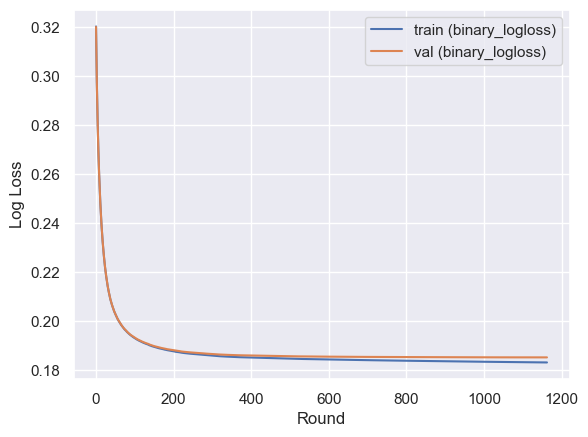

Log loss train: 0.18318459119643807
Log loss val:  0.18521957250390178


In [3]:
params = dict(
    learning_rate=0.05,
    objective="binary",
    metric="binary_logloss",
    #min_data_in_leaf=200,
    num_leaves=6,
    verbose=0,
    seed=0,
)

evals_result = {}
train_data = lgb.Dataset(X_D2_train, label=E_D2_train)
val_data = lgb.Dataset(X_D2_val, label=E_D2_val)

start_time = time.time()

lgb_model_D2 = lgb.train(
    params,
    train_set=train_data,
    valid_sets=[train_data, val_data],
    valid_names=["train", "val"],
    num_boost_round=3000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=20),
        lgb.record_evaluation(evals_result),
    ],
)

print(f"Fitting time: {time.time() - start_time:.2f} seconds")

for dataset in evals_result.keys():
    metric_values = evals_result[dataset]["binary_logloss"]
    plt.plot(metric_values, label=f"{dataset} (binary_logloss)")
plt.xlabel("Round")
plt.ylabel("Log Loss")
plt.legend()
plt.show()

print("Log loss train: " + str(log_loss(E_D2_train, lgb_model_D2.predict(X_D2_train))))
print("Log loss val:  " + str(log_loss(E_D2_val, lgb_model_D2.predict(X_D2_val))))

In [10]:
lv = np.log(pred) > -999
log_loss(y_D2_test["event"][lv], pred[lv])

0.1851502659819147

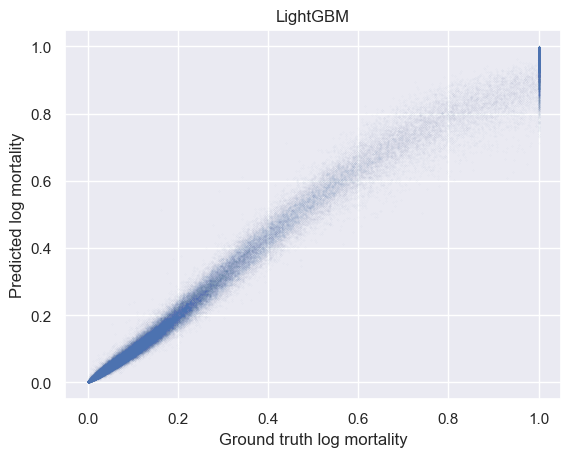

In [9]:
plt.plot((mu_D2_test), (pred), '.', alpha=0.1, markersize=0.25)
plt.title("LightGBM")
plt.xlabel("Ground truth log mortality")
plt.ylabel("Predicted log mortality")
plt.show()

In [8]:
# C-index
pred = lgb_model_D2.predict(X_D2_test)
c_index = concordance_index_censored(y_D2_test["event"], y_D2_test["time"], pred)[0]
print(f"C-index: {c_index:.4f}")

# IBS
lambdas = -np.log(1 - pred) / 10
time_grid = np.arange(1,10)
surv_preds = np.exp(-np.outer(lambdas, time_grid))  # S(t) = exp(-lambda * t)
ibs = integrated_brier_score(y_D2_test, y_D2_test, surv_preds, time_grid)
print(f"Integrated Brier Score: {ibs:.4f}")

# Log loss
logloss = log_loss(y_D2_test["event"], pred)
print(f"Log loss for interval [0, 10): {logloss:.4f}")

C-index: 0.9080
Integrated Brier Score: 0.0372
Log loss for interval [0, 10): 0.1852


In [13]:
events = (y_D2_test["event"]).astype(int)
mse = np.mean(np.square(np.log(mu_D2_test) - np.log(pred)))
dev = -2*np.sum(events*logit(pred) + np.log(1-pred))
kld = -np.sum(np.log(pred[events==1]))
print(f"MSE wrt log ground truth:    {mse:.4f}")
print(f"Logistic deviance:           {dev:.0f}")
print(f"Kullback-Leibler divergence: {kld:.0f}")

MSE wrt log ground truth:    0.0347
Logistic deviance:           101936
Kullback-Leibler divergence: 32977


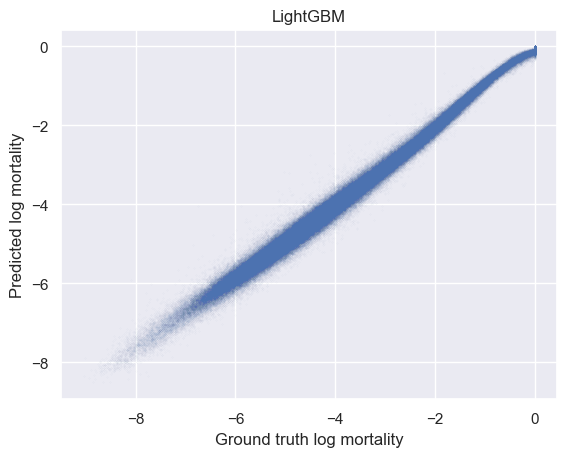

In [14]:
plt.plot(np.log(mu_D2_test), np.log(pred), '.', alpha=0.1, markersize=0.25)
plt.title("LightGBM")
plt.xlabel("Ground truth log mortality")
plt.ylabel("Predicted log mortality")
plt.show()

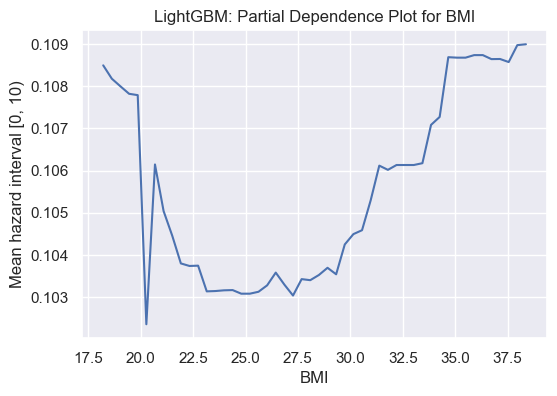

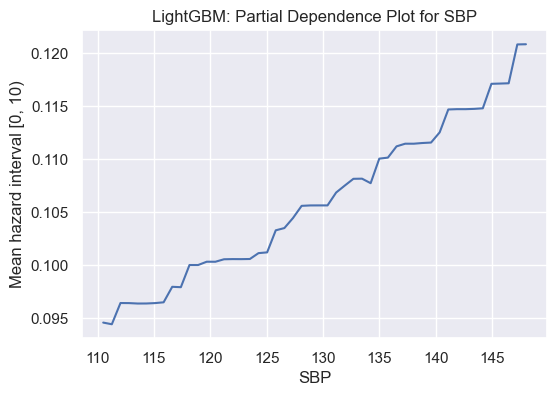

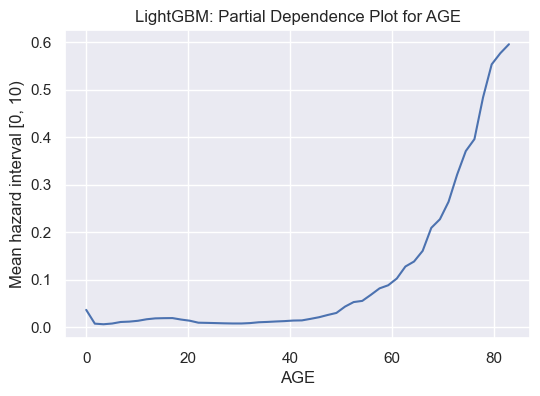

In [11]:
for var in ["BMI", "SBP", "AGE"]:
    plot_pdp(lgb_model_D2, X_D2_test, var, 0, 10)

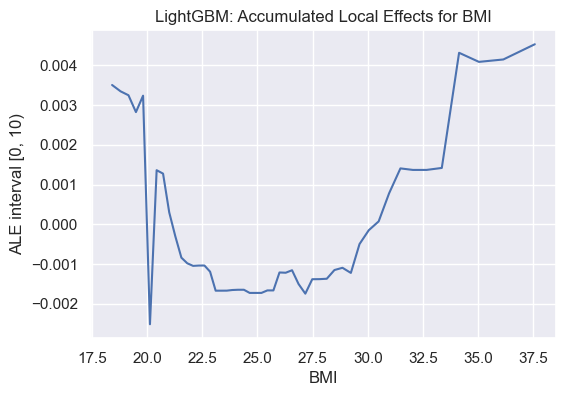

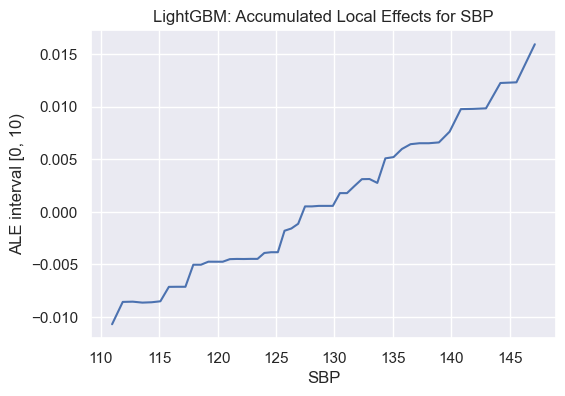

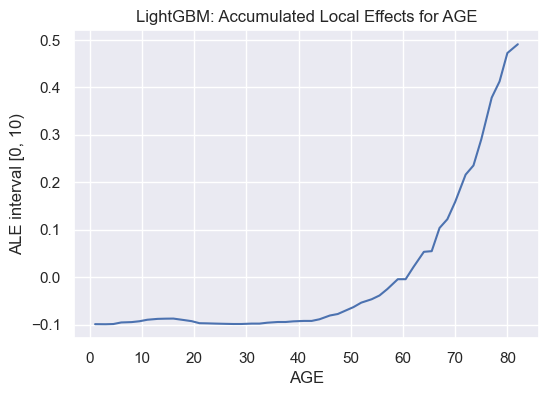

In [12]:
for var in ["BMI", "SBP", "AGE"]:
    plot_ale(lgb_model_D2, X_D2_test, var, 0, 10)